### DATA 620 - Final Project

   ### PubMed Author-Keyword Exploration using Text Mining and Network Analysis
   

#### Keith Folsom
#### Date: 12/19/2017

### Project Overview:

This project examines the relationship between authors and abstracts using a combination of text mining and network analysis using publications sourced from PubMed.  PubMed, available at https://www.ncbi.nlm.nih.gov/pubmed/, provides open access to biomedical and genomic information.  The information available on PubMed is highly structured in XML or MEDLINE format with fields such as PubMed ID, author name, date of publication, and title.   However, the abstract information available with each publication presents a challenge as it is unstructured text, typically dense with medical or scientific terminology. 

The need to understand who publishing research within a disease state is particularly relevant for several reasons to: (1) create an understanding of the landscape of who is publishing medical or scientific content, especially when looking into a new disease state, (2) understand authors’ importance relative to their peers, and (3) understand peer relationships and influence among authors.  

### Approach

This project will use term frequency as well as term frequency-inverse document frequency (TFIDF) as a term-weighting schemes to analyze authors and their association with abstract keywords.  Single-mode and two-mode graphs will be used for visualizing these relationships.  Segmentation of authors will be done using community detection.  Finally, topic modeling will be applied to understand the topics within the author communities.

Video Link: https://drive.google.com/open?id=1Xn1EVzw1TbTlGxkjaAINZNl4EZAUUn3w



### Load the Necessary Packages

The main packages used are:

1. pandas
2. numpy
3. Biopython for PubMed publication extraction (http://biopython.org/)
4. community
5. nltk
6. sklearn
7. networkx



In [132]:
import pandas as pd
import numpy as np
import re
import string
%matplotlib inline
import matplotlib.pyplot as plt
from Bio import Entrez, Medline

import community
from community import community_louvain

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from collections import Counter

from nltk.corpus.reader.plaintext import PlaintextCorpusReader

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import networkx as nx
import networkx.algorithms.bipartite as bipartite
from networkx.algorithms import components

from itertools import count
from operator import itemgetter
import seaborn as sns
import math
import os

# set a default figure size
plt.rcParams['figure.figsize'] = (21, 14)

### Data Sourcing

Using Biopython, extract publications from PubMed matching the term "malignant melanoma" published between 2016 and 2017.  The MEDLINE record type will be used for this particular extract.

In [2]:
Entrez.email = "kdf73@yahoo.com"     # tell NCBI who you are

handle = Entrez.esearch(db="pubmed", term="malignant melanoma", sort='relevance', retmax=1000, mindate=2016, maxdate=2017)   
record = Entrez.read(handle)
idlist = record["IdList"]

handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
records = Medline.parse(handle)

publications = list(records)

###  Information on the MEDLINE record layourout

 see http://biopython.org/DIST/docs/api/Bio.Medline.Record-class.html

             # Mnemonic  Description
             # |  --------- ------------------------------
             # |  AB        Abstract
             # |  AD        Affiliation
             # |  AID       Article Identifier  (maybe)
             # |  AU        Author
             # |  FAU       Full Author
             # |  DEP       Date of Electronic Publication
             # |  DP        Date of Publication
             # |  EDAT      Entrez Date     
             # |  IP        Issue
             # |  TA        Journal Title Abbreviation
             # |  JT        Journal Title
             # |  LA        Language
             # |  OT        Other Term
             # |  OWN       Owner
             # |  PL        Place of Publication
             # |  PHST      Publication History Status
             # |  PST       Publication Status
             # |  PT        Publication Type
             # |  PMID      PubMed Unique Identifier
             # |  SO        Source
             # |  STAT      Status
             # |  TI        Title

In [3]:

pubs_df = pd.DataFrame(columns=['lead_author', 'abstract', 'mesh', 'other_terms', 'tokens', 'keywords', 'lead_author_std'])

for i, pub_record in enumerate(publications):   
    pubs_df.loc[i] =  pub_record.get("FAU", "?")[0], \
                      pub_record.get("AB", "?"),     \
                      pub_record.get("MH", "?"),     \
                      pub_record.get("OT", "?"),     \
                      None, None, None
    
    # convert the author full name to a standard lastName, First Initial format
    # Names are captured in varying formats on publications
    pubs_df.loc[i].lead_author_std = pubs_df.loc[i].lead_author [0:pubs_df.loc[i].lead_author.find(',', 0) + 3]  


# remove entries where the lead author is not available
# remove entries where the abstract is not available
pubs_df = pubs_df[pubs_df.lead_author != "?"]
pubs_df = pubs_df[pubs_df.abstract != "?"]


pubs_df.head()

lead_author                                           abstract  \
0          Qin, Jin  This study aims to investigate the influence o...   
1         Fang, Wei  Dysregulated microRNA (miR)-625 expression has...   
2      Barut, Figen  The evidence that PITX1 (pituitary homeobox 1)...   
3         Wang, Hao  Although gene therapy has brought new insights...   
4  Munien, Carmelle  The 37kDa/67kDa laminin receptor (LRP/LR) is a...   

                                                mesh  \
0  [Animals, Apoptosis/*radiation effects, Apopto...   
1  [3' Untranslated Regions/genetics, Animals, Ce...   
2  [Adolescent, Adult, Aged, *Disease Progression...   
3  [Adaptor Proteins, Signal Transducing/*genetic...   
4  [Antibodies, Neoplasm/*pharmacology, Antibodie...   

                                         other_terms tokens keywords  \
0  [*Malignant melanoma, *X-ray, *apoptosis, *hea...   None     None   
1  [SOX2, malignant melanoma, miR-625, tumorigene...   None     None   
2  [*Cutaneous malignant melanoma, *Ki-67, *Pitui...   None     None   
3  [Livin, Small interfering RNA, malignant melan...   None     None   
4  [37kDa/67kDa laminin receptor (LRP/LR), Adhesi...   None     None   

  lead_author_std  
0          Qin, J  
1         Fang, W  
2        Barut, F  
3         Wang, H  
4       Munien, C

### Abstract Word Analysis using NLTK

Create an abstract corpus for an initial understanding of the words contained in the publication abstracts.

In [5]:
pubs_df.abstract.to_csv('abstracts.csv')

current_dir = os.getcwd()

abstract_corpus = PlaintextCorpusReader(current_dir, 'abstracts.csv', encoding='latin-1') 

Gather some high level statistics on the raw corpus. No normalization has been applied yet.

In [6]:
total_files = len(abstract_corpus.fileids())
total_chars = len(abstract_corpus.raw())
total_words = len(abstract_corpus.words())
total_sentences = len(abstract_corpus.sents())


print("===========================")
print("Total Files = {}".format(total_files))    
print("Total Words = {}".format(total_words))
print("Total Sentences = {}".format(total_sentences))


Total Files = 1
Total Words = 226026
Total Sentences = 8584


### Clean up and tokenize 

We're going to consider a word as the set of characters greater than length 1 and non-numeric. Stopwords are removed, plus some additional terms appearing as part of the standard abstract layout such as background, objective, etc. Some normalization is applied such as removal of punctuation and case forced to lowercase. Lemmatization is not applied.

In [9]:
#Clean up the abstract corpus

stop = stopwords.words('english')
stop.append("new")
stop.append("BACKGROUND:")
stop.append("AIM:")
stop.append("OBJECTIVE:")
stop = set(stop)

abstract_terms = [word.lower() for word in abstract_corpus.words()]

# remove special characters
pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
abstract_terms = filter(None, [pattern.sub('', token) for token in abstract_terms])

abstract_terms = [word for word in abstract_terms if len(word) > 1]
abstract_terms = [word for word in abstract_terms if not word.isnumeric()]
abstract_terms = [word for word in abstract_terms if word not in stop]

# show some terms
abstract_terms[1:10]

['aims',
 'investigate',
 'influence',
 'high',
 'linear',
 'energy',
 'transfer',
 'let',
 'heavy']

### Word Frequency Distribution

Review the 200 most frequently occurring single words, bigrams, and trigrams.

In [8]:
# build the frequency distribution 
fdist = nltk.FreqDist(abstract_terms)

# what are the 200 most common words appearing in the abstracts
fdist200_df = pd.DataFrame(fdist.most_common(200),columns=['word','count'])
fdist200_df


word  count
0         melanoma   3642
1         patients   1464
2        malignant   1286
3            cells    873
4            tumor    716
5             cell    688
6       expression    661
7         survival    646
8        treatment    628
9            study    569
10         results    522
11         primary    514
12          cancer    485
13              mm    479
14      metastatic    437
15        clinical    398
16         disease    395
17      associated    367
18       melanomas    360
19           cases    358
20         patient    356
21       cutaneous    353
22       diagnosis    353
23           stage    345
24        analysis    344
25            risk    340
26            skin    338
27             may    321
28         therapy    319
29      metastasis    319
..             ...    ...
170      migration    105
171            aim    105
172            due    103
173            iii    102
174  immunotherapy    102
175      evaluated    102
176     ipilimumab    102
177       detected    101
178        outcome    101
179      resection    101
180        without    101
181     regression    100
182             cm    100
183       included     99
184     aggressive     99
185        genetic     99
186           oral     98
187       although     97
188      decreased     96
189      objective     96
190     diagnostic     95
191         number     95
192      signaling     95
193           nevi     95
194           vivo     94
195    melanocytes     94
196    combination     94
197      effective     93
198          ratio     93
199        tissues     93

[200 rows x 2 columns]

In [10]:
# look at bigrams 
bigrams = ngrams(abstract_terms, 2)  

Counter(bigrams).most_common(100)

[(('malignant', 'melanoma'), 983),
 (('melanoma', 'cells'), 285),
 (('melanoma', 'patients'), 171),
 (('cutaneous', 'melanoma'), 169),
 (('lymph', 'node'), 160),
 (('metastatic', 'melanoma'), 141),
 (('overall', 'survival'), 133),
 (('year', 'old'), 132),
 (('cell', 'lines'), 129),
 (('melanoma', 'cell'), 126),
 (('skin', 'cancer'), 95),
 (('free', 'survival'), 91),
 (('pet', 'ct'), 80),
 (('cutaneous', 'malignant'), 79),
 (('present', 'study'), 78),
 (('melanoma', 'mm'), 75),
 (('uveal', 'melanoma'), 68),
 (('primary', 'malignant'), 67),
 (('cell', 'proliferation'), 66),
 (('cell', 'cycle'), 66),
 (('poor', 'prognosis'), 63),
 (('stage', 'iii'), 62),
 (('malignant', 'melanomas'), 56),
 (('sentinel', 'lymph'), 56),
 (('tumor', 'cells'), 54),
 (('head', 'neck'), 54),
 (('confidence', 'interval'), 53),
 (('pd', 'l1'), 53),
 (('hif', '1alpha'), 52),
 (('lymph', 'nodes'), 51),
 (('a375', 'cells'), 51),
 (('melanoma', 'progression'), 50),
 (('patients', 'melanoma'), 50),
 (('aim', 'study'),

In [11]:
# look at trigrams 
trigrams = ngrams(abstract_terms, 3)  

trigram_freq = Counter(trigrams).most_common(100)

In [13]:
df = pd.DataFrame(columns=['word1', 'word2', 'word3', 'freq'])

df['word1'] = [x[0] for x,s in trigram_freq]
df['word2'] = [x[1] for x,s in trigram_freq]
df['word3'] = [x[2] for x,s in trigram_freq]
df['freq'] =  [s for x,s in trigram_freq]

df['weight'] =  df['freq']/df['freq'].sum()  * 100  # arbitrarily set at 100 for weighting 

df.head(10)

word1      word2     word3  freq    weight
0   malignant   melanoma        mm    74  3.858186
1   cutaneous  malignant  melanoma    72  3.753910
2    melanoma       cell     lines    64  3.336809
3     primary  malignant  melanoma    54  2.815433
4    sentinel      lymph      node    49  2.554745
5   malignant   melanoma     cells    42  2.189781
6  metastatic  malignant  melanoma    38  1.981230
7        year        old       man    36  1.876955
8        case       year       old    31  1.616267
9       lymph       node    biopsy    30  1.564129

Let's consider the abstract trigrams as a single mode network and visualize the result.

Name: 
Type: Graph
Number of nodes: 290
Number of edges: 224
Average degree:   1.5448


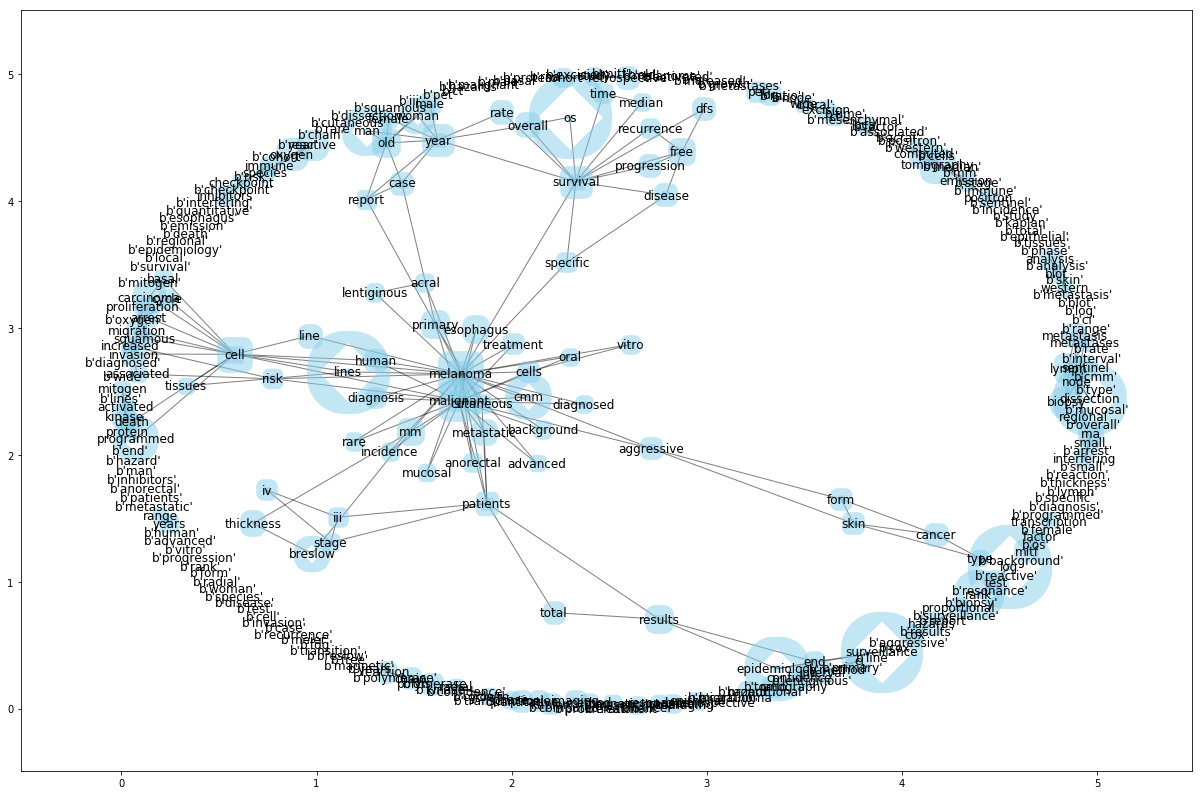

In [14]:
nodes = list(set(df.word1).union(df.word2).union(df.word3))

G = nx.Graph()

for index, row in enumerate(nodes):
    word = row.encode('ascii', 'ignore')
    G.add_node(word)

G.add_weighted_edges_from([(row['word1'], row['word2'], row['weight']) for idx, row in df.iterrows()])
G.add_weighted_edges_from([(row['word2'], row['word3'], row['weight']) for idx, row in df.iterrows()])
G.add_weighted_edges_from([(row['word1'], row['word3'], row['weight']) for idx, row in df.iterrows()])

print(nx.info(G))

pos = nx.spring_layout(G, scale=5)

# use one of the edge properties to control line thickness
edgewidth = [ d['weight']* 20 for (u,v,d) in G.edges(data=True)]


ns =[v*20 for v in G.degree().values()] # node size

nx.draw_networkx(G, pos=pos, with_labels=True, node_size=ns, 
                 node_color="skyblue", node_shape="s", alpha=0.5, linewidths=edgewidth)
plt.show()

The graph representation is interesting but difficult to derive any deeper understanding.  Consider a single word ego-graph, in this case using the word "squamos."  As expected, the radius 3 network of words around the keyword squamos show a collection of triads.  We can start do develop an understanding of the words surrounding specific keywords but what about their relationship to an author?

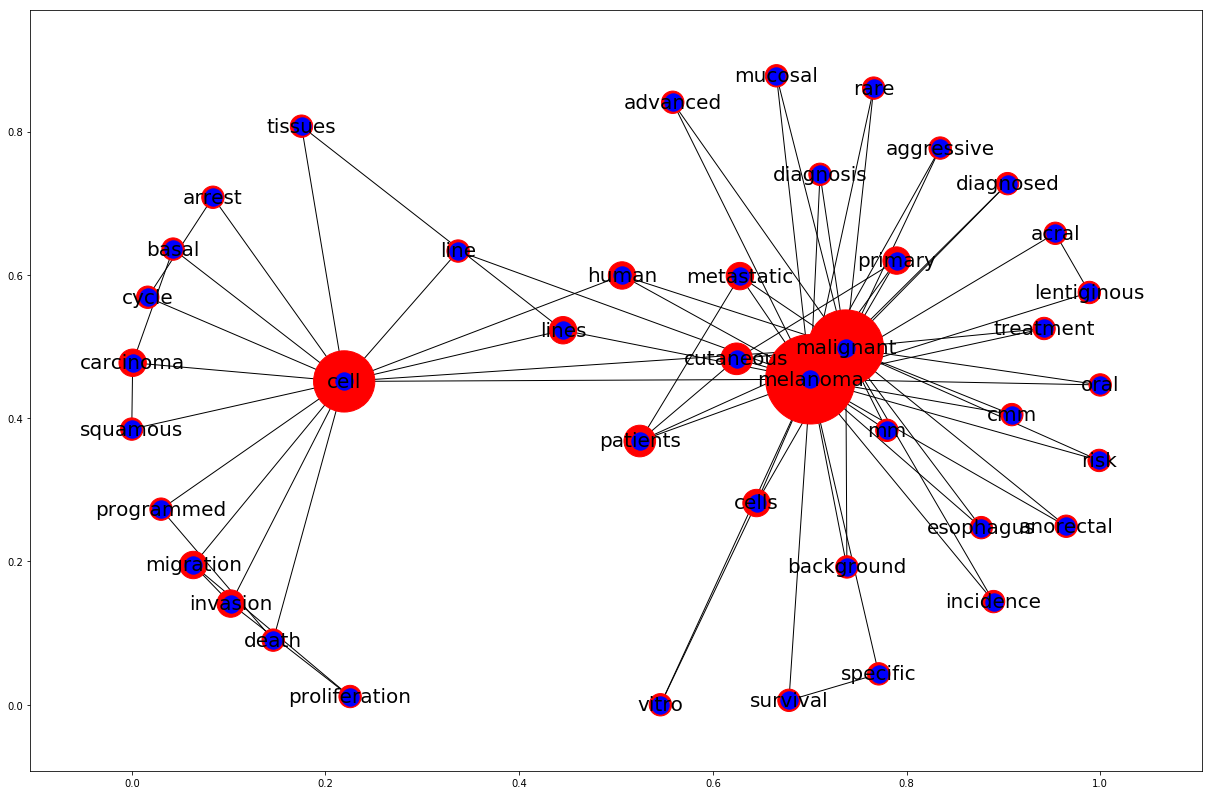

In [15]:
ego_graph = nx.Graph(nx.ego_graph(G, "squamous", radius=3))
graphDegree = nx.degree(ego_graph)
pos = nx.spring_layout(ego_graph)

nx.draw_networkx(ego_graph, pos, node_size = [v * 250 for v in graphDegree.values()],
                with_labels=True, font_size = 20)


nx.draw_networkx_nodes(ego_graph, pos, node_list=['squamous'],
                node_size=300, node_color='b')


plt.show()

## Authors

Authors and co-authors are provided in the MEDLINE record layout.  The lead author is listed in the first position with co-authors following in order.  An author's name can have multiple formats across different publications.  To reduce issues with name variation, a standardized author name is derived from the Author Full Name field which uses a format of last name, first initial. This may lead to over-collapsing some authors together but introduces less error than the alternative.

In [16]:
author_df = pubs_df[['lead_author_std','abstract']].sort_values("lead_author_std")

author_df.head(10)

lead_author_std                                           abstract
311  Abdel-Rahman, O  BACKGROUND: Population-based data on the clini...
650  Abdel-Rahman, O  AIM: This meta-analysis aims at assessing the ...
204    Afasizheva, A  BACKGROUND: Intrinsic and acquired resistance ...
308         Afzal, M  INTRODUCTION: Interferon alpha 2B (IFN-alpha) ...
41        Agarwal, P  Malignant melanoma is one of the most aggressi...
807       Agarwal, P  Primary malignant melanoma of the vagina is an...
901         Aires, D  New melanoma drugs bring enormous benefits but...
724   Al-Qurayshi, Z  OBJECTIVE: Head and neck cutaneous melanoma re...
560       Alamodi, A  Human malignant melanoma is a highly aggressiv...
659       Alarifi, S  The present work was designed to investigate t...

For this analysis, we're going to look at an author's body of work in total.  To do this, combine all of an author's abstracts together.

In [17]:
# combine all lead authors abstracts together
author_pubs = []
abstract = ""
pub_count = 0
for idx, author in enumerate(list(set(author_df.lead_author_std))):
    
    for index, row in author_df[author_df.lead_author_std == author].iterrows():
        #pub_count = 0
        abstract += " " + row['abstract']
        pub_count = pub_count + 1
        
    author_pubs.append((author, abstract, pub_count))
    abstract = ""
    pub_count = 0
    
    

As an example, the author Abdel-Rahman, O is shown with two publications above.  These will be collapsed into a single abstract text field.

In [19]:
auth_df = pd.DataFrame(author_pubs, columns=['lead_author', 'abstracts', 'publication_count'])

auth_df[auth_df.lead_author=="Abdel-Rahman, O"]


lead_author                                          abstracts  \
323  Abdel-Rahman, O   BACKGROUND: Population-based data on the clin...   

     publication_count  
323                  2

### Tokenize the abstract text associated with each author

Tokenize the abstract text for each author to generate keywords.  This process applies similar rules as above but now include lemmatization.  The goal of this step is to associate keywords and their frequency to each author.

In [20]:

wnl = WordNetLemmatizer() 

def tokenizer(text):
 
    tokenized = [word_tokenize(sent) for sent in sent_tokenize(text)]
 
    tokens = []
    for token_by_sent in tokenized:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t.lower() not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    

    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
 
    return filtered_tokens


def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [21]:
articles = []
for index, row in auth_df.iterrows():
    
    document = tokenizer(row['abstracts'])
    top_10 = get_keywords(document, 10)

    articles.append((row['lead_author'],  top_10))
    
pubs_kw_df = pd.DataFrame(articles, columns=['lead_author', 'kw'])

pubs_kw_df.head(20)

lead_author                                                 kw
0      Noguchi, T  [(mm, 4), (melanoma, 3), (primary, 3), (cervix...
1   Kakkassery, V  [(muc4, 9), (cmm, 7), (around, 6), (vessel, 6)...
2        Ozaki, Y  [(treatment, 8), (pseudoprogression, 5), (case...
3       Tjarks, B  [(melanoma, 12), (follicular, 8), (involvement...
4         Sula, B  [(patient, 8), (melanoma, 7), (n, 6), (stage, ...
5         Jose, A  [(melanoma, 4), (ipilimumab, 3), (patient, 3),...
6          Lim, A  [(melanoma, 8), (vitamin, 8), (tumour, 6), (p,...
7      Umansky, V  [(ccr5, 10), (mdscs, 7), (melanoma, 6), (tumor...
8        Rossi, U  [(melanoma, 9), (cell, 9), (ifnbeta, 5), (btz,...
9     Saunders, R  [(malignant, 6), (melanocytic, 5), (skin, 5), ...
10      Hasebe, M  [(outcome, 6), (patient, 5), (cirt, 5), (tnr, ...
11    Kadowaki, Y  [(ws, 5), (nasal, 5), (malignant, 4), (patient...
12     Comoglu, S  [(hn-pmmm, 4), (mitotic, 4), (activity, 4), (p...
13       Thapa, S  [(melanoma, 11), (study, 4), (malignant, 3), (...
14  Karpathiou, G  [(endobronchial, 5), (tumor, 5), (melanoma, 4)...
15  Harrington, E  [(melanoma, 7), (study, 7), (diagnosis, 4), (r...
16       Singh, H  [(case, 4), (oral, 2), (malignant, 2), (melano...
17         Gao, D  [(study, 7), (ldh, 7), (ci, 7), (melanoma, 6),...
18   McWhirter, E  [(patient, 7), (cediranib, 4), (median, 4), (d...
19       Patil, M  [(dmm, 4), (melanoma, 2), (clinical, 2), (case...

In [23]:
pubs_kw_df[pubs_kw_df.lead_author=="Abdel-Rahman, O"]

lead_author                                                 kw
323  Abdel-Rahman, O  [(p, 11), (patient, 10), (metastasis, 8), (met...

### Analysis Using Bipartite Graphs 

To incorporate the author into the analysis, examine authors and keywords as a two-mode or bipartite graph.  Authors and their connection to keywords will be used to create relationships between the nodes; edge weight will be assigned based on the frequency.

In [24]:
G = nx.Graph()

for index, row in pubs_kw_df.iterrows():
    
    G.add_node(row['lead_author'], bipartite=0)
      
    for (word, freq) in row['kw']:
        G.add_node(word, bipartite=1) 
        G.add_weighted_edges_from([(row['lead_author'], word, freq)])    

In [25]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3207
Number of edges: 8320
Average degree:   5.1886


In [26]:
print("Bipartite Network G\n  Bipartite: {}\n  Connected: {}".format(nx.is_bipartite(G), 
                                                                     nx.is_connected(G)))

Bipartite Network G
  Bipartite: True
  Connected: True


Using networkx to plot the author-keyword network shows a complicated visualization which makes it difficult to discern anything specific.

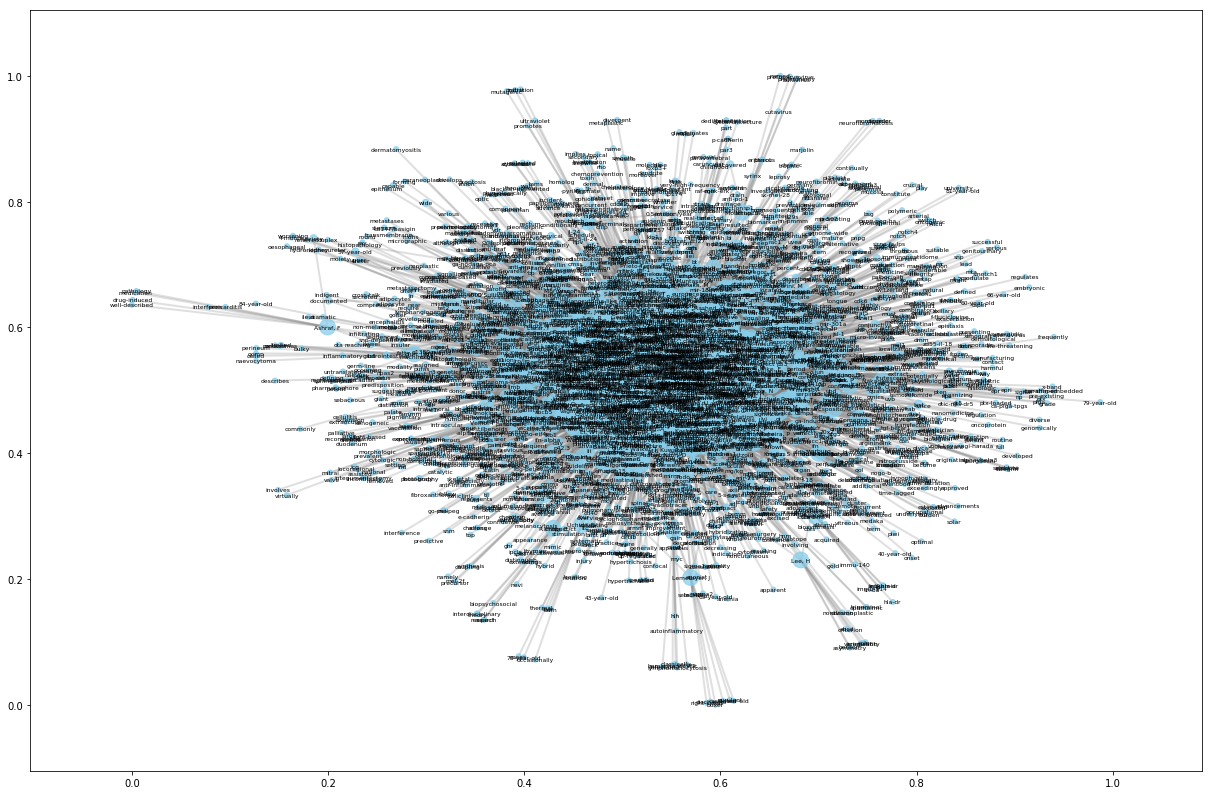

In [33]:
ns =[v*25 for v in G.degree().values()] # node size

position=nx.spring_layout(G)

nx.draw_networkx_nodes(G, position, node_color="skyblue",
        node_size = ns,
        alpha=0.75,
        with_labels=True)

nx.draw_networkx_edges(G,pos=position,edge_color='grey',width=2,
    alpha=0.25)

nx.draw_networkx_labels(G,pos=position,font_size=6)

plt.show()


#### Let's modify the approach to include only the higher degree nodes to reduce the graph above.

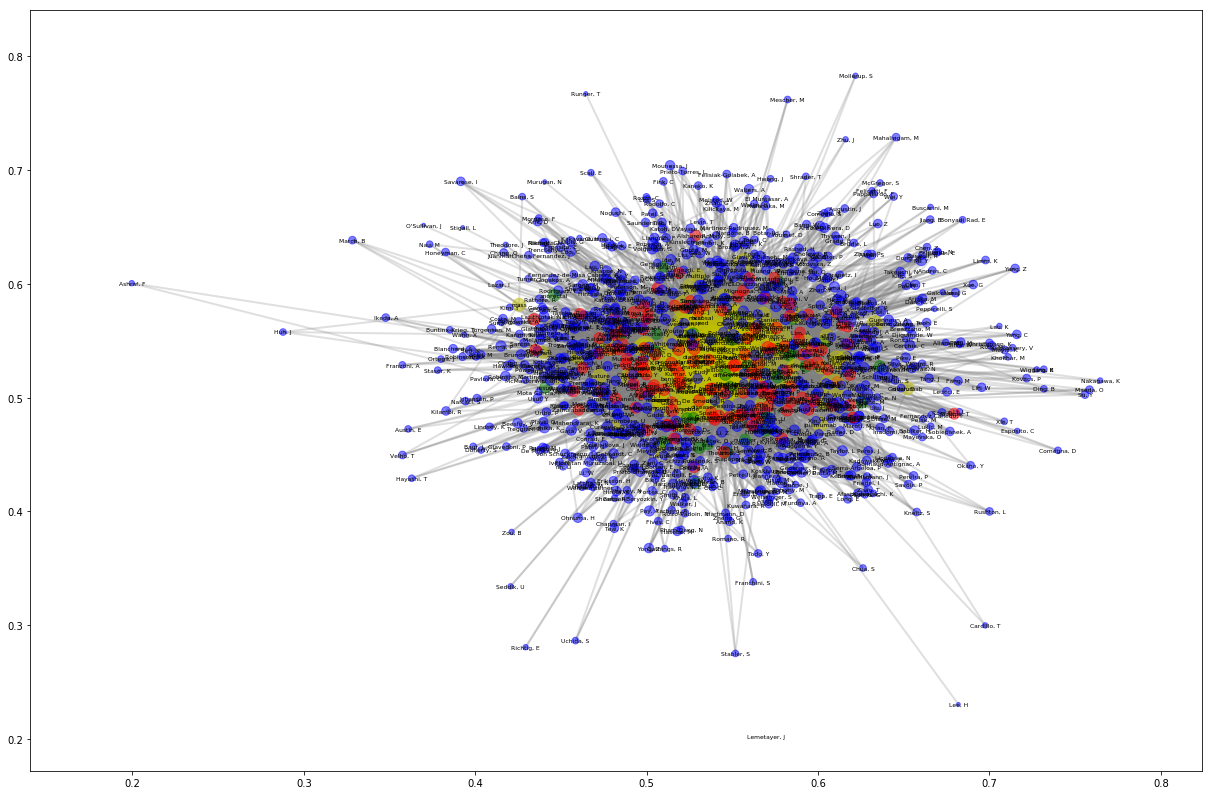

In [37]:
G_degree_trimmed = G.copy()

deg = G.degree()
remove = [n for n in deg if deg[n] <= 7]
G_degree_trimmed.remove_nodes_from(remove)

colors=[]
for n, d in G_degree_trimmed.nodes(data=True):
    if d['bipartite']==1:    # bipartite = 1 indicates the keywords
        if G_degree_trimmed.degree(n) > 9:
            colors.append('y')   
        else: 
            colors.append('g')
    else:                      # bipartite = 0 indicates the authors                               
        if G_degree_trimmed.degree(n) > 7: 
            colors.append('r')
        else:
            colors.append('b') 

ns = [v*15 for v in G_degree_trimmed.degree().values()]
#nx.draw_networkx(G_degree_trimmed, with_labels=True, 
                 #node_size=ns, node_color=colors, node_shape="s", alpha=0.5, linewidths=20)



nx.draw_networkx_nodes(G_degree_trimmed, position, node_color=colors,
        node_size = ns,
        alpha=0.5,
        with_labels=True)

nx.draw_networkx_edges(G_degree_trimmed,pos=position,edge_color='grey',width=2,
    alpha=0.25)

nx.draw_networkx_labels(G_degree_trimmed,pos=position,font_size=6)


plt.show()

#### The resulting visualization is still difficult to interpet.  Let's consider communities within the network as a means to look at smaller segments.

In [41]:
partitions = community_louvain.best_partition(G)
set(partitions.values())

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24}

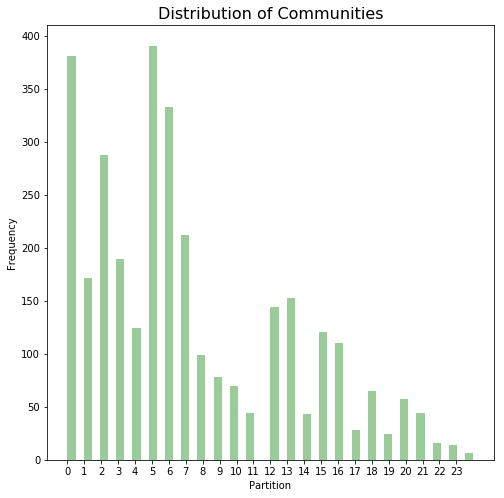

In [56]:
plt.figure(figsize=(8,8))
plt.xticks(np.arange(0,24,1))
plt.xlabel("Partition")
plt.ylabel("Frequency")
plt.title("Distribution of Communities", fontsize=16)
sns.distplot(list(partitions.values()), bins=50, color='g', kde=False)
plt.show()

The result of Louvain community detection using the concept of modularity recommends 25 subgroups.  Possibly too many to work with but let's visualize a few to see what they look like.

In [38]:
nx.set_node_attributes(G, 'partition', partitions)
nx.set_node_attributes(G, 'ev', nx.eigenvector_centrality_numpy(G))

In [60]:
def draw_partition(partition):
    
    G_partition = G.copy()

    remove = [n for n in G_partition.nodes() if G_partition.node[n]['partition'] != partition]
    deg = G_partition.degree()

    remove += [n for n in deg if deg[n] < 7 ]
    G_partition.remove_nodes_from(remove)

    colors=[]
    ns=[]
    for n, d in G_partition.nodes(data=True):
        if d['bipartite']==1:    # bipartite = 1 indicates the keywords
                colors.append('y')   
                #node_shape.append('o')  # seems like you cannot specific a different shape for nodes like this
                ns.append( 350 * G_partition.degree(n)) 
        else:                      # bipartite = 0 indicates the authors                               

                colors.append('r')
                #node_shape.append('s')
                ns.append(300 * G_partition.degree(n)) 


    position=nx.random_layout(G_partition)


    weights = [math.log(edata['weight']) for f,t,edata in G_partition.edges(data=True)]

    nx.draw_networkx_nodes(G_partition, position, node_color=colors,
            node_size = ns,
            alpha=0.75,
            with_labels=True)

    nx.draw_networkx_edges(G_partition,pos=position,edge_color='grey',width=weights,
        alpha=0.25)

    nx.draw_networkx_labels(G_partition,pos=position,font_size=14)

    plt.title("Network Visualization of Community #%d" % partition, fontsize=16)
    # display the graph
    plt.show()


### Visualize the network in select communities

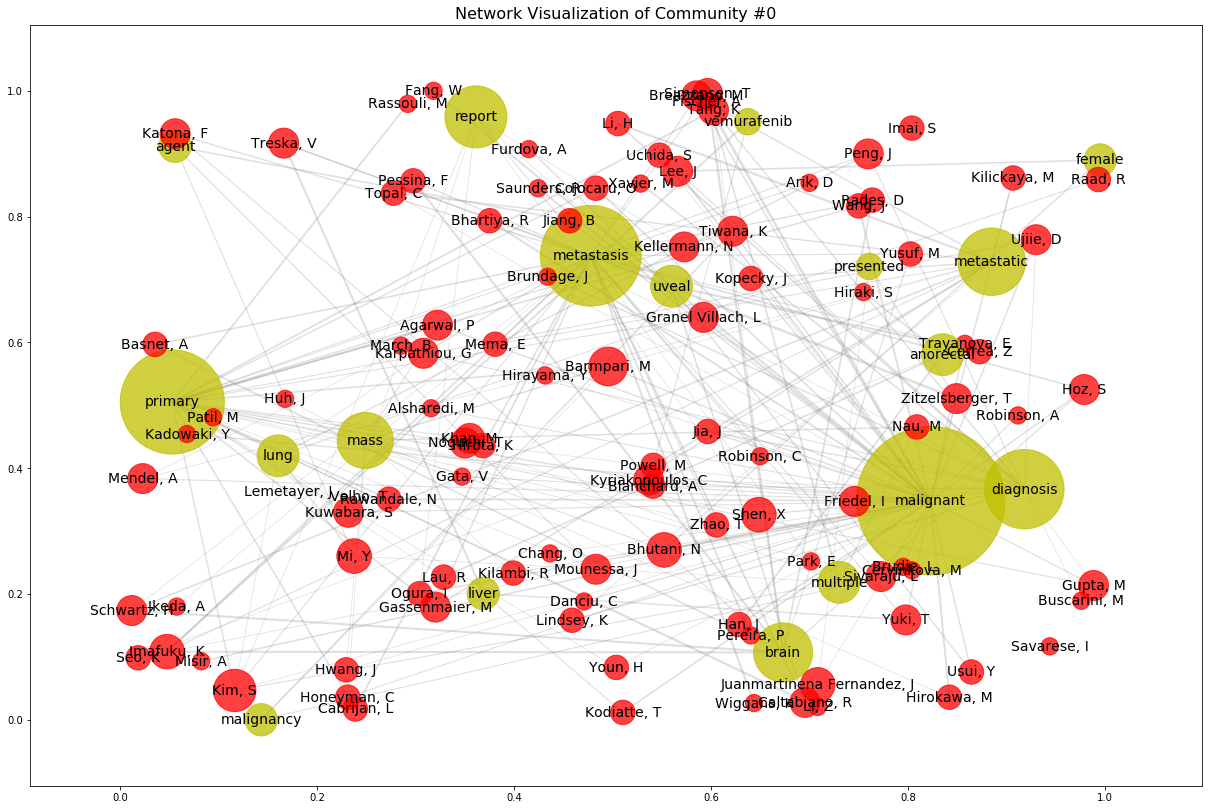

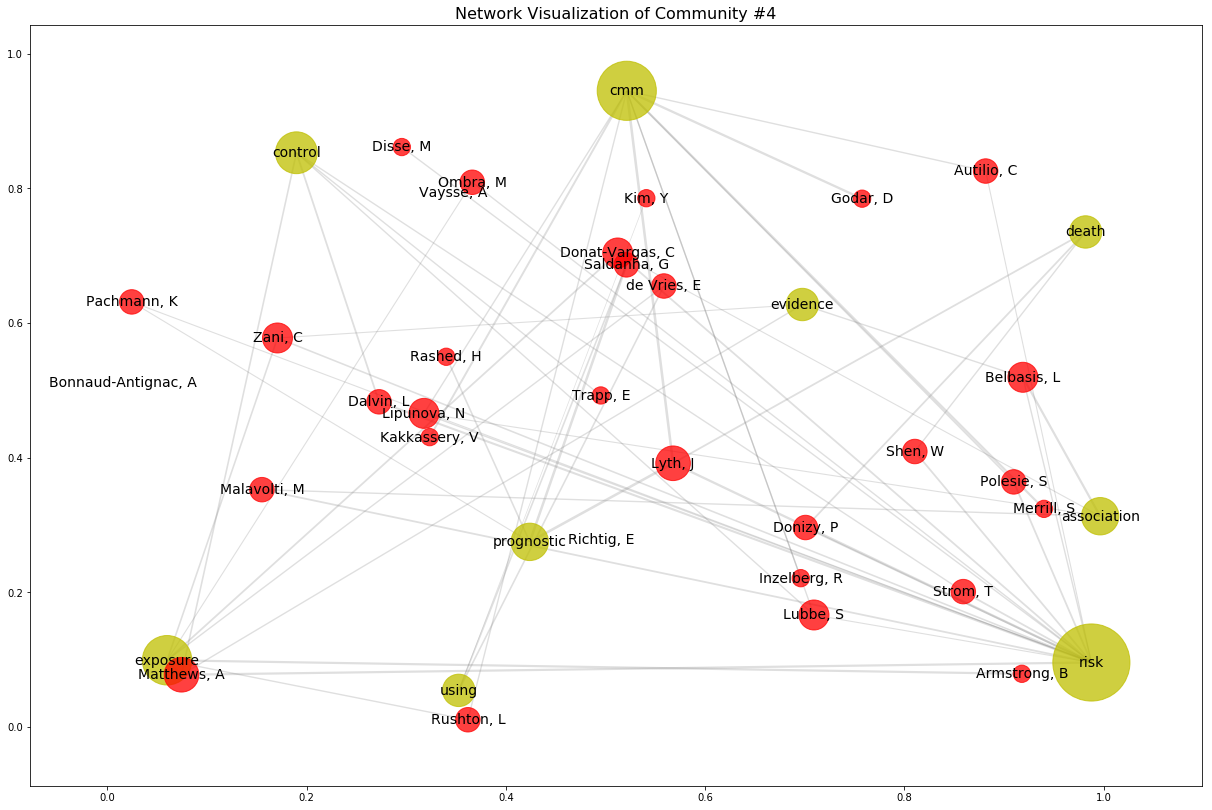

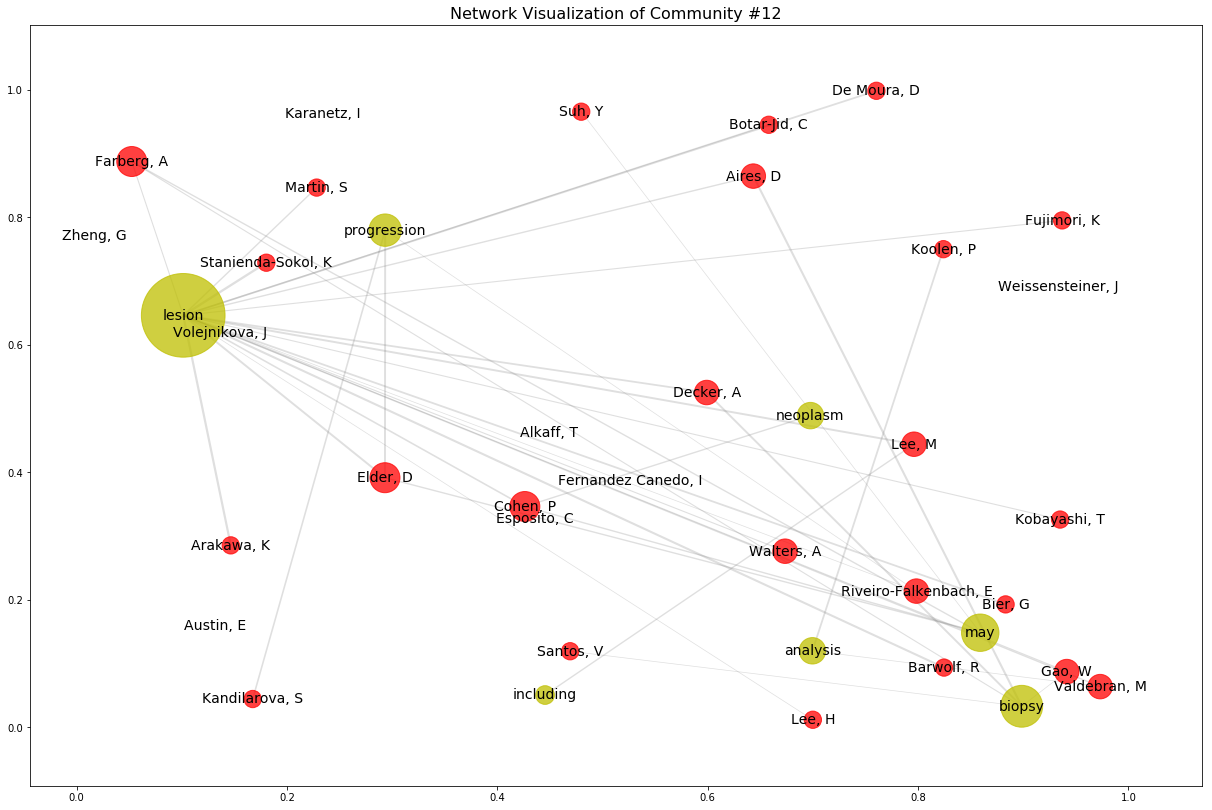

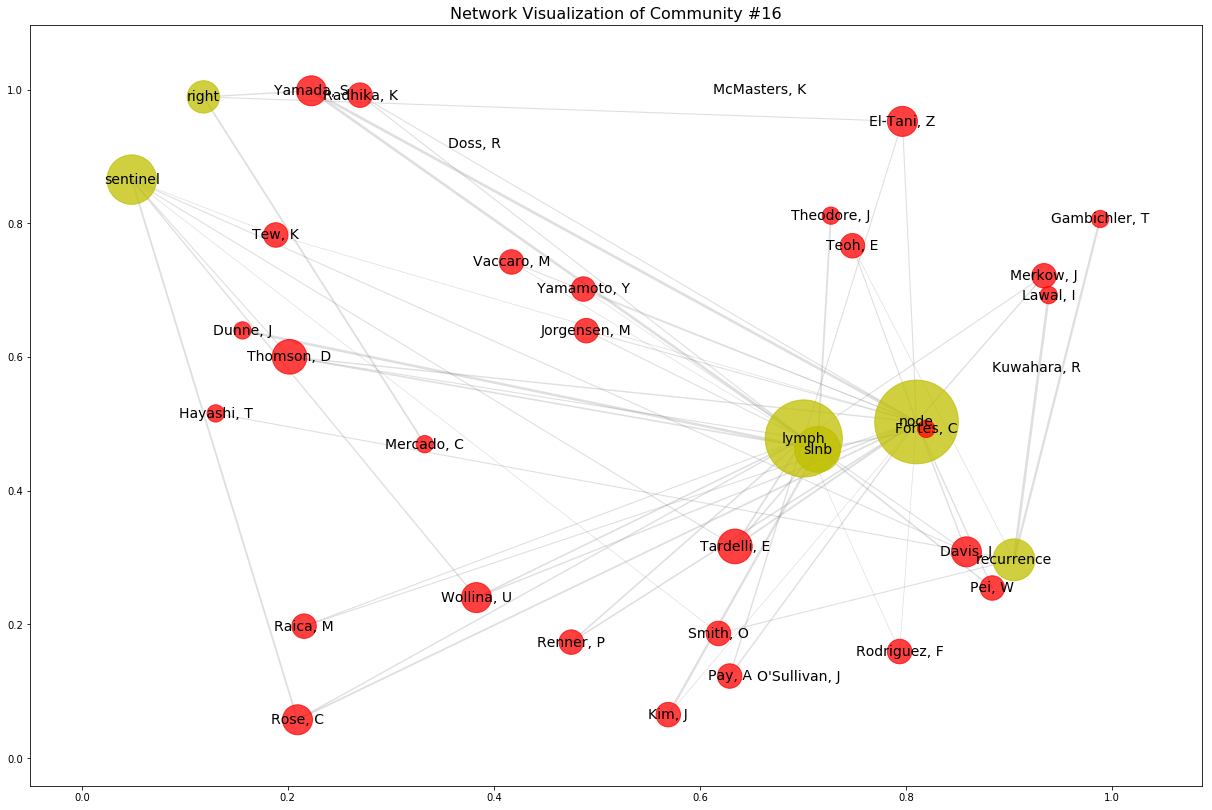

[None, None, None, None]

In [62]:
[draw_partition(n) for n in (0, 4, 12, 16)]

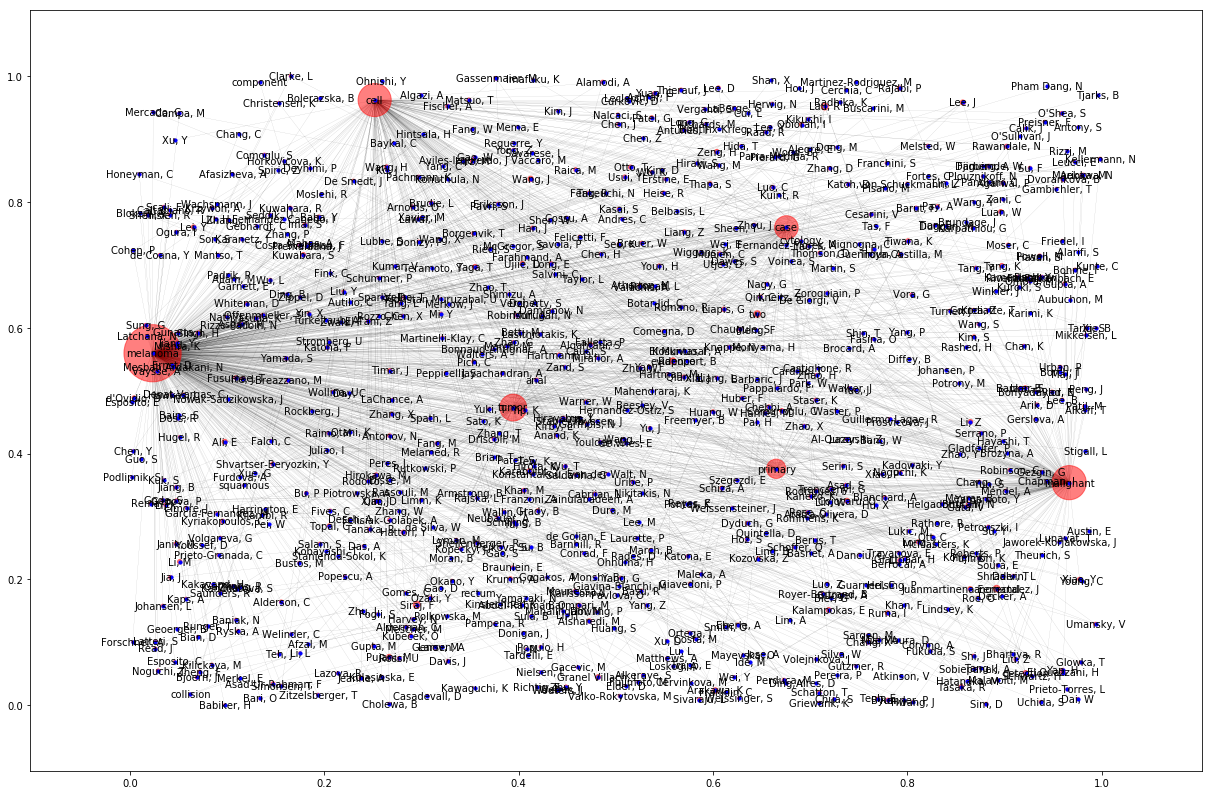

In [100]:
ego_graph = nx.Graph(nx.ego_graph(G, "squamous", radius=3))
graphDegree = nx.degree(ego_graph)
pos = nx.random_layout(ego_graph)

nx.draw_networkx(ego_graph, pos, node_size = [v * 5 for v in graphDegree.values()],
                with_labels=True, font_size = 10, width=.1, alpha=0.5)


nx.draw_networkx_nodes(ego_graph, pos, node_list=['squamous'],
                node_size=10, node_color='b')

#nx.draw_networkx_edges(ego_graph,pos,edge_color='grey',width=.5,
#        alpha=0.25)

plt.show()
    

### Try the Island Method 

In [70]:
authors, keywords = nx.bipartite.sets(G)

len(authors), len(keywords)

(832, 2375)

In [71]:
A = nx.bipartite.weighted_projected_graph(G, authors, ratio=False)

In [72]:
print(nx.info(A))

Name: 
Type: Graph
Number of nodes: 832
Number of edges: 258980
Average degree: 622.5481


In [39]:
print(nx.info(K))

Name: 
Type: Graph
Number of nodes: 2418
Number of edges: 26754
Average degree:  22.1290


In [73]:
# Trim edges function is taken directly from SNABook

def trim_edges(g, weight=1):
    """
    Remove edges with weights less then a threshold parameter ("weight")
    """
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2


def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [76]:
## Apply Island Analysis on the women nodes
cc = list(nx.connected_component_subgraphs(A))[0]
islands = island_method(cc)

print('Weight  Authors  Groups')
for i in islands:
    print(' %d      %2d      %d' 
          %(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Authors  Groups
 1      831      1
 2      791      1
 3      598      13
 4      276      46
 5      45      17
 6       4      2
 7       2      1


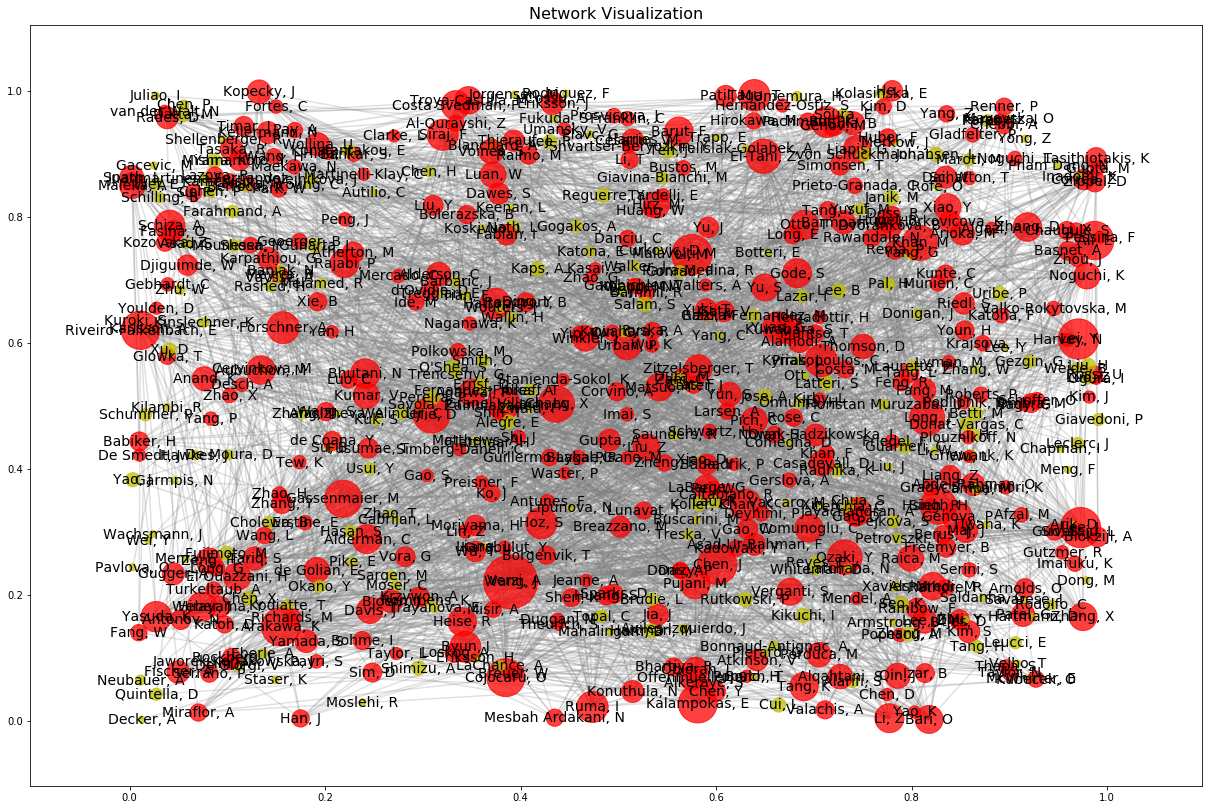

In [102]:
# apply a minimum weight 3 water level
Asub3 = trim_edges(A, 3)
Asub3 = list(nx.connected_component_subgraphs(Asub3))[0]

colors=[]
ns=[]
for n, d in Asub3.nodes(data=True):
    if Asub3.degree(n) < 5:    # bipartite = 1 indicates the keywords
            colors.append('y')   
            #node_shape.append('o')  # seems like you cannot specific a different shape for nodes like this
            ns.append( 50 * Asub3.degree(n)) 
    else:                      # bipartite = 0 indicates the authors                               

            colors.append('r')
            #node_shape.append('s')
            ns.append(30 * Asub3.degree(n)) 


position=nx.random_layout(Asub3)


weights = [math.log(edata['weight']) for f,t,edata in Asub3.edges(data=True)]

nx.draw_networkx_nodes(Asub3, position, node_color=colors,
        node_size = ns,
        alpha=0.75,
        with_labels=True)

nx.draw_networkx_edges(Asub3,pos=position,edge_color='grey',width=weights,
    alpha=0.25)

nx.draw_networkx_labels(Asub3, pos=position,font_size=14)

plt.title("Network Visualization", fontsize=16)
# display the graph
plt.show()

Using the Island Method to reduce the size of the network, it's still difficult to discern any meaningful insight.

In [104]:
deg = nx.degree_centrality(A)                       # Run degree centrality
bet = nx.betweenness_centrality(A)                  # Run betweenness centrality
eig = nx.eigenvector_centrality(A)                  # Run eigenvector centrality
clos = nx.closeness_centrality(A)
partitions = community_louvain.best_partition(A)

In [105]:
# Assign each to an attribute in your network
nx.set_node_attributes(A, 'degree', deg)
nx.set_node_attributes(A, 'eigenvector', eig)
nx.set_node_attributes(A, 'betweenness', bet)
nx.set_node_attributes(A, 'closeness', clos)
nx.set_node_attributes(A, 'partition', partitions)

In [106]:
graph = A.nodes(data = True)

data={}

data['node'] = [x[0] for x in graph]
data['degree'] = [x[1]['degree'] for x in graph]
data['eigenvector'] = [x[1]['eigenvector'] for x in graph]
data['betweenness'] = [x[1]['betweenness'] for x in graph]
data['closeness'] = [x[1]['closeness'] for x in graph]
data['partition'] = [x[1]['partition'] for x in graph]

# load into a data frame
A_df = pd.DataFrame(data)
A_df = A_df.set_index(['node'])

In [107]:
A_df.sort_values(by=['eigenvector'], ascending=[0]).head(10)

betweenness  closeness    degree  eigenvector  partition
node                                                                 
Wang, J         0.000734   0.945392  0.942238     0.065019          2
Chen, J         0.000691   0.937923  0.933815     0.058633          2
Lee, J          0.000698   0.930571  0.925391     0.055287          1
Schiza, A       0.000825   0.945392  0.942238     0.055031          1
Arakawa, K      0.000531   0.914191  0.906137     0.054008          1
Matsuo, T       0.000626   0.931614  0.926594     0.053957          2
Barut, F        0.000590   0.921286  0.914561     0.053635          1
Ujiie, D        0.000439   0.910186  0.901324     0.053472          0
Cojocaru, O     0.000518   0.899351  0.888087     0.053372          2
Byun, J         0.000744   0.921286  0.914561     0.052541          1

In [108]:
def get_top_users_by_community(g, partitions, top=3):
    lst = []
    
    for i, n in enumerate(partitions):
    
        # First get a list of just the nodes in that class
        class_nodes = [n for n in g.nodes() if g.node[n]['partition'] == i]

        # Then create a dictionary of the eigenvector centralities of those nodes
        class_eigenvector = {n:g.node[n]['eigenvector'] for n in class_nodes}

        # Then sort that dictionary and print the first 5 results
        class_sorted_by_eigenvector = sorted(class_eigenvector.items(), key=itemgetter(1), reverse=True)

        #print("Parition {} Sorted by Eigenvector Centrality:".format(i))
        for node in class_sorted_by_eigenvector[:top]:
         
           lst.append([i, node[0], node[1]])
    
    return lst

In [109]:
top = get_top_users_by_community(A, set(partitions.values()), 10)

top

[[0, 'Ujiie, D', 0.053472114109903934],
 [0, 'Kalampokas, E', 0.0506972483164866],
 [0, 'Granel Villach, L', 0.04875314256488856],
 [0, 'Ali, E', 0.048686073893114426],
 [0, 'Singh, H', 0.04831124246627384],
 [0, 'Obiorah, I', 0.048052975035123034],
 [0, 'Khan, M', 0.04684945801576281],
 [0, 'Taga, T', 0.04657996858776716],
 [0, 'Comunoglu, C', 0.04564445378048381],
 [0, 'Jia, J', 0.04529111767947722],
 [1, 'Lee, J', 0.05528720443329129],
 [1, 'Schiza, A', 0.0550313331764409],
 [1, 'Arakawa, K', 0.05400844199597016],
 [1, 'Barut, F', 0.0536352567011326],
 [1, 'Byun, J', 0.052540912941250316],
 [1, 'Ozaki, Y', 0.052454561740800695],
 [1, 'El-Tani, Z', 0.05185800056980876],
 [1, 'Yuan, G', 0.05060445972783053],
 [1, 'Zitzelsberger, T', 0.05028233910756311],
 [1, 'Genova, P', 0.050179676479714774],
 [2, 'Wang, J', 0.0650191978490197],
 [2, 'Chen, J', 0.058632830494944596],
 [2, 'Matsuo, T', 0.05395735239179478],
 [2, 'Cojocaru, O', 0.0533721549401138],
 [2, 'Zhang, Y', 0.05235672289563128

### Alternate Approach Using Term Frequency-Inverse Document Frequency (TFIDF)

The approaches below use features from scikit-learn.



In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(min_df=1, max_df=100, stop_words='english', ngram_range=(1, 1))

all_weights_df = pd.DataFrame()

for index, row in auth_df.iterrows():
    
    tokens = tokenizer(row['abstracts'])
    tvec_weights = tvec.fit_transform(tokens)    #tvec.fit_transform(row['abstracts'].split('\n'))
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
      
    weights_df = pd.DataFrame({'lead_author': row['lead_author'], 'term': tvec.get_feature_names(), 'weight': weights})
    # append to a single dataframe for all authors with weights
    all_weights_df = all_weights_df.append(weights_df, ignore_index=True)

In [112]:
G = nx.Graph()

df = all_weights_df.groupby('lead_author').head(10).reset_index(drop=True)

for index, row in df.iterrows():
    G.add_node(row['lead_author'], bipartite=0)
    G.add_node(row['term'], bipartite=1)

# edges
G.add_weighted_edges_from([(row['lead_author'], row['term'], row['weight']) for idx, row in df.iterrows()])

    

In [114]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2581
Number of edges: 8320
Average degree:   6.4471


In [116]:
authors, keywords = nx.bipartite.sets(G)

len(authors), len(keywords)

(832, 1749)

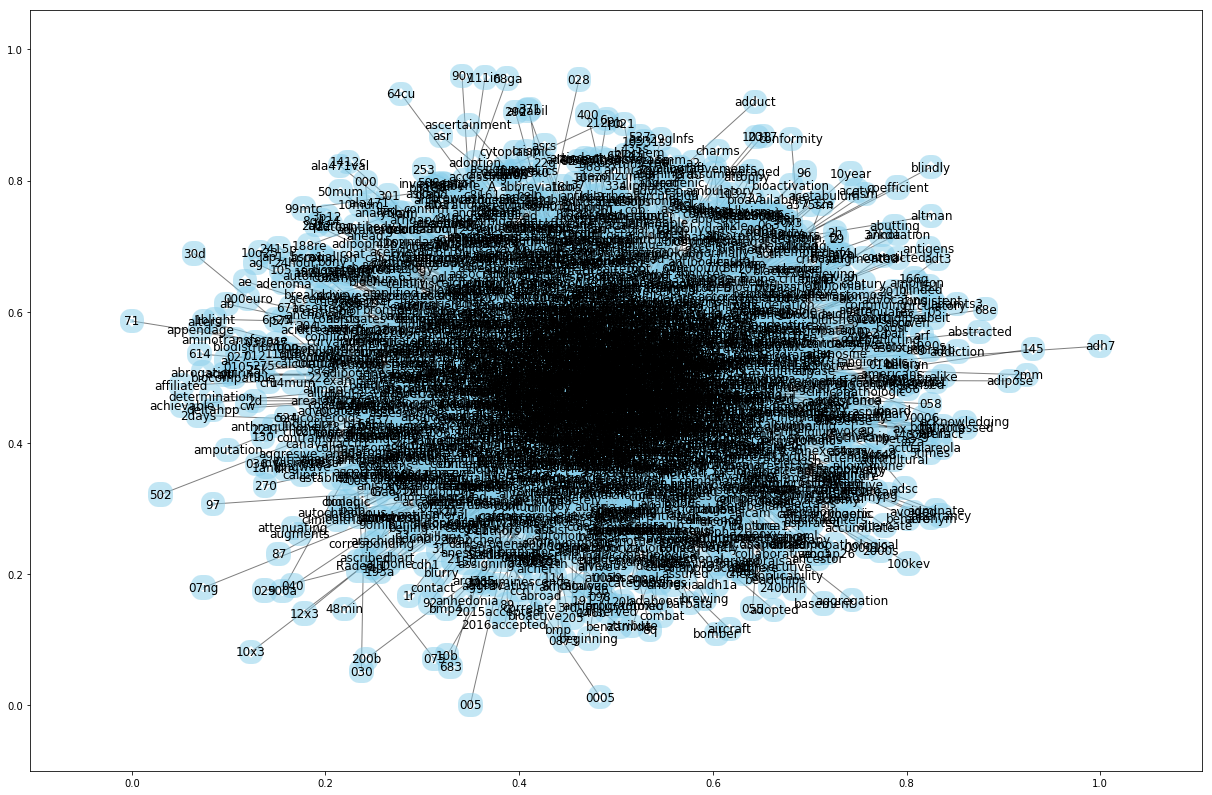

In [120]:
ns =[v*20 for v in G.degree().values()] # node size

nx.draw_networkx(G, with_labels=True, node_size=ns, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=20)
plt.show()

Again, the visualization is still difficult to discern.  Let's apply community detection to further segment the analysis.

#### Create a weighted projected graph of Authors

In [122]:
A = nx.bipartite.weighted_projected_graph(G, authors, ratio=False)
K = nx.bipartite.weighted_projected_graph(G, keywords, ratio=False)

Revisting the community concept as means to identify subgroups, we see that there are now four distinct communities within the projeted author network.

In [123]:
partitions = community_louvain.best_partition(A)
set(partitions.values())

{0, 1, 2, 3}

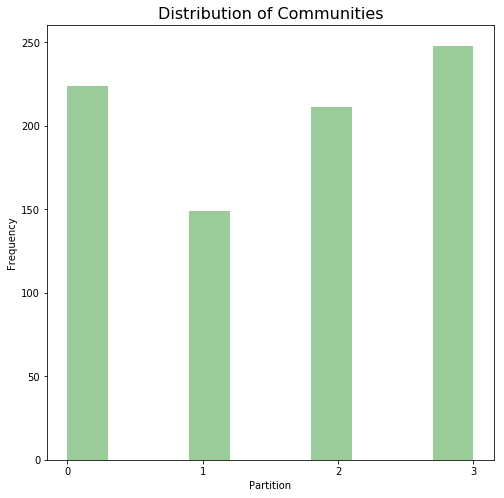

In [125]:
plt.figure(figsize=(8,8))
plt.xticks(np.arange(0,24,1))
plt.xlabel("Partition")
plt.ylabel("Frequency")
plt.title("Distribution of Communities", fontsize=16)
sns.distplot(list(partitions.values()), bins=10, color='g', kde=False)
plt.show()

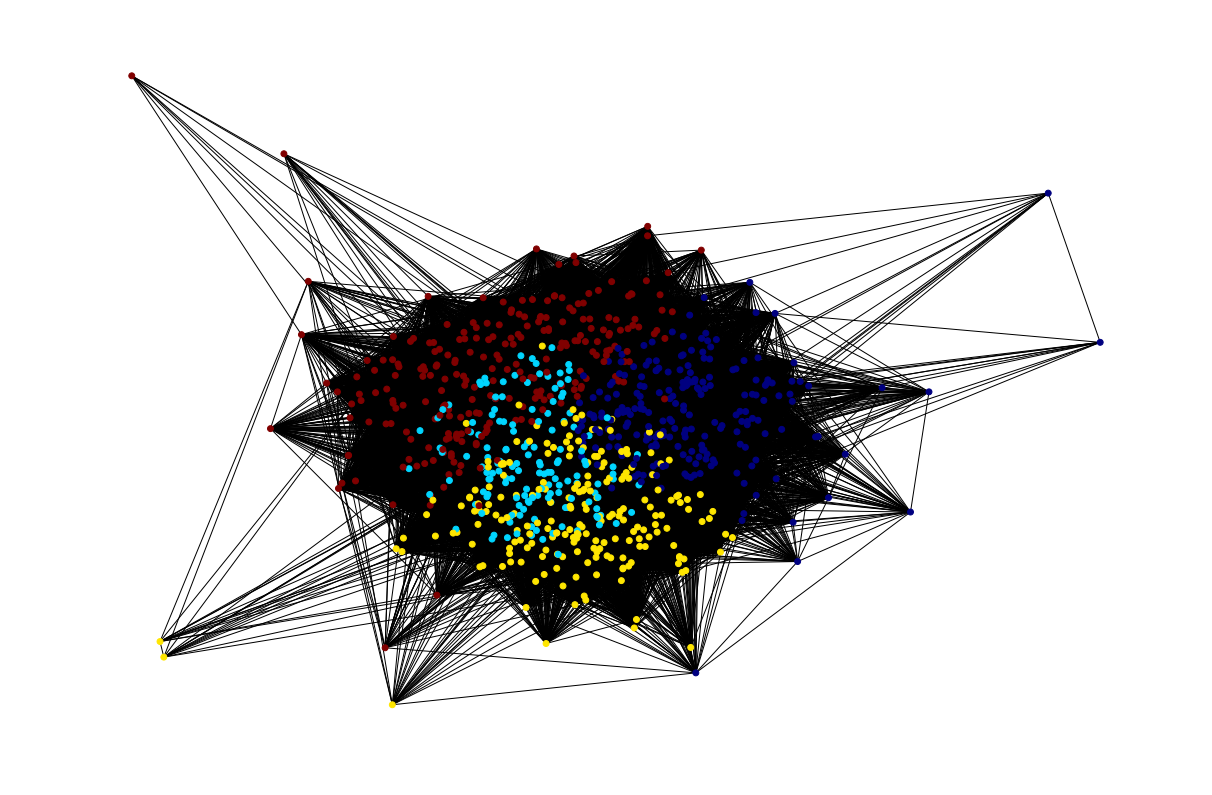

In [126]:
values = [partitions.get(node) for node in A.nodes()]
spring_pos = nx.spring_layout(A)
plt.axis("off")
nx.draw_networkx(A, pos = spring_pos, 
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = 35, with_labels = False)

In [127]:
# set the partition as a node attribute
nx.set_node_attributes(A, 'partition', partitions)

In [128]:
graph = A.nodes(data = True)

data={}

data['lead_author'] = [x[0] for x in graph]
data['partition'] = [x[1]['partition'] for x in graph]

# load into a data frame
A_df = pd.DataFrame(data)

A_df.head()

lead_author  partition
0     Noguchi, T          0
1      Tjarks, B          0
2  Kakkassery, V          1
3       Ozaki, Y          0
4        Sula, B          2

### Topic Modeling

With a smaller set of communities, we'll investigate the use of topic modeling as a potential means to better different authors.

Topic modeling uses non-negative matrix factorization (MNF) using scikit-learn.  Topic extraction using LDA is another option but not used in this analysis.

The work here is largely based on the NMF techniques found below.

#### Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation¶

#### Author: Olivier Grisel <olivier.grisel@ensta.org>
####         Lars Buitinck
####         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
#### License: BSD 3 clause

This is an example of applying :class:sklearn.decomposition.NMF and :class:sklearn.decomposition.LatentDirichletAllocation on a corpus of documents and extract additive models of the topic structure of the corpus. The output is a list of topics, each represented as a list of terms (weights are not shown).

Non-negative Matrix Factorization is applied with two different objective functions: the Frobenius norm, and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make the example runnable in a couple of tens of seconds. You can try to increase the dimensions of the problem, but be aware that the time complexity is polynomial in NMF. In LDA, the time complexity is proportional to (n_samples * iterations).


In [136]:
n_samples = 2000
n_features = 1000
n_components = 5
n_top_words = 20

def print_top_words(model, feature_names, n_top_words, partition):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def get_top_words(model, feature_names, n_top_words, partition):
    out = []
    for topic_idx, topic in enumerate(model.components_):
        #message = "Topic #%d: " % topic_idx
        message = " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        out.append((partition, topic_idx, message))

    return out 

def get_topics_mnf(df, partition):
    
    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=10, min_df=3,  #max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')

    tfidf = tfidf_vectorizer.fit_transform(df)

    #tf = tf_vectorizer.fit_transform(auth_df.abstracts)

    # Fit the NMF model
    print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..." % (n_samples, n_features))

    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nPartition %d:" % partition)
    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words, partition)
    
      
    return get_top_words(nmf, tfidf_feature_names, n_top_words, partition)
    
    

### Perform Topic extraction within each partition

In [137]:

all_topics_df = pd.DataFrame()
for i in list(set(partitions.values())):
    #topics = get_topics_mnf(auth_df[auth_df.partition == i], 0)
    topic_df = pd.DataFrame(get_topics_mnf(auth_df[auth_df.partition == i].abstracts, i),
                            columns=['partition', 'topic_number', 'topic'])
    
    all_topics_df = all_topics_df.append(topic_df, ignore_index=True)
    

Extracting tf-idf features for NMF...
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...

Partition 0:

Topics in NMF model (Frobenius norm):
Topic #0: pd cmm controls genes susceptibility cohort phase gene independent variant nivolumab kit cd8 studied ci assess ii geographic quality 001
Topic #1: esophagus pmme esophageal esophagectomy previous thoracoscopic alive lymphadenectomy laparoscopic endoscopic suggestive hmb45 dysphagia gastric suspected radical squamous spindle endoscopy referred
Topic #2: congenital nevi proliferative nodules giant scalp challenging adult suggest diagnostically marker method emphasize sign lentiginous mediastinal appear children naevi anterior
Topic #3: nasal epistaxis endoscopic thyroid pedunculated consider clinicians possibility successfully sinonasal approach removed posterior resonance magnetic exists concurrent organs discharge counterpart
Topic #4: pleural effusion pulmonary secondary published causes 

#### Let's look at the top 5 topics per author partition

What do these topics, and more specifically, the tokens look like if we view them as a graph?

In [138]:
all_topics_df.head(50)

partition  topic_number                                              topic
0           0             0  pd cmm controls genes susceptibility cohort ph...
1           0             1  esophagus pmme esophageal esophagectomy previo...
2           0             2  congenital nevi proliferative nodules giant sc...
3           0             3  nasal epistaxis endoscopic thyroid pedunculate...
4           0             4  pleural effusion pulmonary secondary published...
5           1             0  pd l1 pembrolizumab anti programmed ctla block...
6           1             1  mir overexpression a375 tissues microrna assay...
7           1             2  um uveal class negative akt 82 intraocular exh...
8           1             3  cmm populations born vessels localization wome...
9           1             4  nevus nevi count mean dysplastic breslow preva...
10          2             0  exposure exposed numbers sun burden attributab...
11          2             1  pet fdg tomography accuracy uptake met prevale...
12          2             2  mir serum functional tissues pcr vitro migrati...
13          2             3  slnb blue sln dye dissection dfs procedure com...
14          2             4  alpha ifn dfs complete interferon duration poi...
15          3             0  vitamin 25 vemurafenib sun modification antipr...
16          3             1  1alpha hif hypoxia glycolysis inducible p27 wm...
17          3             2  nf kappab manner pain pcr exogenous microscopy...
18          3             3  nivolumab working oncolytic pembrolizumab admi...
19          3             4  emt mesenchymal epithelial transition cadherin...

In [139]:
G2 = nx.Graph()

for idx, row in all_topics_df.iterrows():  
    
    G2.add_node(row['partition'], bipartite=0)
    #nx.set_node_attribute(G2, 'partition',row['partition'] )
    
    for i in row['topic'].split(" "):
        word = i.encode('ascii', 'ignore')
        G2.add_node(word, bipartite=1) 
        G2.add_edges_from([(row['partition'], word)])

print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 370
Number of edges: 392
Average degree:   2.1189


In [140]:
partition, keyword = nx.bipartite.sets(G2)

len(partition), len(keyword)

(4, 366)

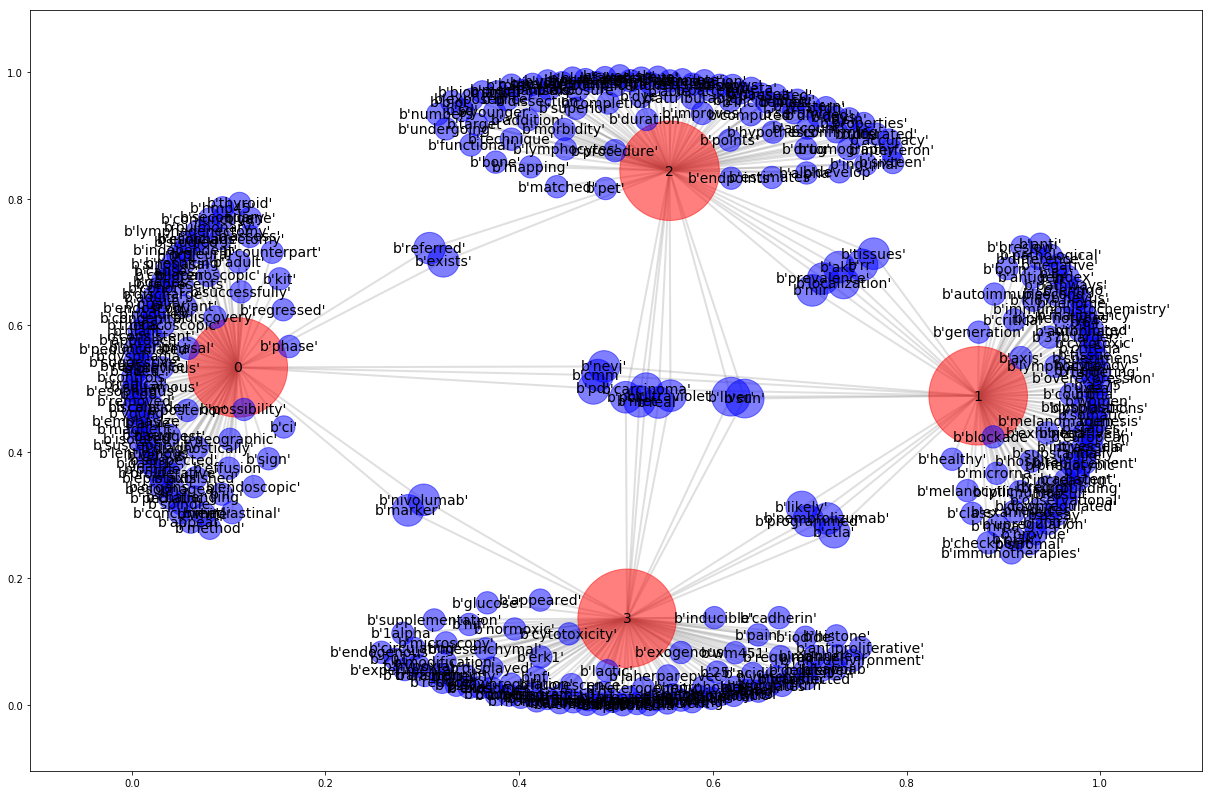

In [144]:
colors=[]
ns=[]
for n, d in G2.nodes(data=True):
    if d['bipartite']==1:    # bipartite = 1 indicates the keywords
            colors.append('b')               
            ns.append( 500 * G2.degree(n)) 
    else:                      # bipartite = 0 indicates the partition                              

            colors.append('r')            
            ns.append(100 * G2.degree(n)) 


position=nx.spring_layout(G2)

nx.draw_networkx_nodes(G2, position, node_color=colors,
        node_size = ns,
        alpha=0.5,
        with_labels=True)

nx.draw_networkx_edges(G2,pos=position,edge_color='grey',width=2,
    alpha=0.25)

nx.draw_networkx_labels(G2,pos=position,font_size=14)

# display the graph
plt.show()

It's interesting to note that the visualization above shows that specific keyword words are used nearly exclusively within an author partition.  This would require further investigation and verification; however, it does present some interesting opportunities for classifying abstracts and better author segmentation.

For example, we can identify the key authors within a community based on centrality measures.

In [145]:
P = bipartite.weighted_projected_graph(G2, partition, ratio=False)

K = bipartite.weighted_projected_graph(G2, keyword, ratio=False)


In [148]:
def get_top_users_by_community(g, partitions, top=3):
    lst_ev = []
    lst_pg = []
    lst_cc = []
    
    for i, n in enumerate(partitions):

        # First get a list of just the nodes in that class
        class_nodes = [n for n in g.nodes() if g.node[n]['partition'] == i and g.node[n]['bipartite'] == 0]  # authors
        
        #print(class_nodes)
        
        # Then create a dictionary of the eigenvector centralities of those nodes
        class_eigenvector = {n:g.node[n]['partition_ev'] for n in class_nodes}
        class_sorted_by_eigenvector = sorted(class_eigenvector.items(), key=itemgetter(1), reverse=True)
        
        class_pagerank = {n:g.node[n]['partition_pg'] for n in class_nodes}
        class_sorted_by_pagerank = sorted(class_pagerank.items(), key=itemgetter(1), reverse=True)
        
        class_closeness = {n:g.node[n]['partition_cc'] for n in class_nodes}
        class_sorted_by_closeness = sorted(class_closeness.items(), key=itemgetter(1), reverse=True)

        for node in class_sorted_by_eigenvector[:top]:
           lst_ev.append([i, node[0], node[1]])
                                          
        for node in class_sorted_by_pagerank[:top]:
           lst_pg.append([i, node[0], node[1]])
        
        for node in class_sorted_by_closeness[:top]:
           lst_cc.append([i, node[0], node[1]])
    
    return lst_ev, lst_pg, lst_cc

#### Find the 5 Top Authors within each community based on centrality measures.

Note that the centrality measure, in this case eigenvector centrality, has been recalcuate within the community subgraph.

In [155]:
part_ev, part_pg, part_cc = get_top_users_by_community(G, set(auth_df.partition), 5)
part_ev

[[0, 'Robinson, A', 0.17438783468878258],
 [0, 'Dyduch, G', 0.16046353319465903],
 [0, 'Kellermann, N', 0.12283073675130268],
 [0, 'Chua, S', 0.11672646607035411],
 [0, "d'Ovidio, D", 0.10589946386777997],
 [1, 'Pampena, R', 0.15822613999169638],
 [1, 'Al-Qurayshi, Z', 0.15727947145754664],
 [1, 'von Schuckmann, L', 0.12162624937613091],
 [1, 'Botteri, E', 0.12031754871465634],
 [1, 'Malavolti, M', 0.117738325447095],
 [2, 'Peek, M', 0.47213331688626786],
 [2, 'Donigan, J', 0.3088004063632813],
 [2, 'Pham Dang, N', 0.1562971556152502],
 [2, 'Decker, A', 0.1270979129894335],
 [2, 'Shan, X', 0.10620116301441795],
 [3, 'Otani, K', 0.23948986318390694],
 [3, 'Kaneko, K', 0.17489333152785208],
 [3, 'Mignogna, C', 0.1726182395656687],
 [3, 'Krzywon, A', 0.17152690664254083],
 [3, 'Kuroki, S', 0.1513684432676059]]

## Conclusion

This project explored various approaches to better understanding the author-keyword relationships in biomedical publications available through PubMed.  Visualization using bipartite graph or 2-mode graphs offered some potentials insights into these relationships; however, the size of the network presented challenges when attempting to reduce the graph down to a meaningful size. 

Some takeways for future exploration:
* ego-graphs to understand which authors are connected to a keyword seemed useful.  A future enhancement would be to include n-grams to understand more selective and specific phrases.
* The use of tf-idf provided a better set of keywords for the graph
* Visualization would be enhanced through the use of a tool like Gephi or graphviz
* Community detection in combination with topic modeling seemed to be the most promising option for future research